In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

import torch
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import pandas as pd

from src.data.gamma.structural_citeseer import load_dataset, get_train_val_test_edges, prepare_adjencency, get_edge_index_from_adjencency
from src.train.structural_omega.gcn import StructuralOmegaGCNCosSim

/home/caiolmartinelli/.cache/pypoetry/virtualenvs/arxiv-paperclassification-f16XUvnj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
logs_filename = 'logs/omega_function/citeseer/05-1-structural_gcn_cossim_gamma_function.log'

In [4]:
logging.basicConfig(
    format='%(asctime)s - %(levelname)s : %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    filename=logs_filename
)

In [5]:
torch.cuda.is_available()

True

In [6]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

## Data Loading

In [7]:
dataset = load_dataset()

In [8]:
data, edges_train, edges_val, edges_test = get_train_val_test_edges(dataset, device=device)

In [9]:
data = prepare_adjencency(data)

## Training

In [10]:
for run in range(10):
    for n_layers_gcn in range(1, 4):
        omega = StructuralOmegaGCNCosSim(
            device,
            dataset='citeseer',
            in_channels=data.x.shape[1],
            n_layers_gcn=n_layers_gcn,
            run=run,
            eval_steps=10,
            epochs=2000)
        torch.cuda.empty_cache()
        omega.train(edges_train,
                    edges_val,
                    edges_test,
                    data.x,
                    data.y.reshape(-1, 1),
                    data.adj_t)

## Results

### For a Layer Number

In [11]:
n_layers_gcn = 1

In [12]:
metrics = StructuralOmegaGCNCosSim.read_metrics(
    dataset='citeseer',
    n_layers_gcn=n_layers_gcn)
print(metrics.shape)
metrics.head()

(2010, 8)


,run,epoch,loss_train,loss_val,loss_test,auc_train,auc_val,auc_test
0,0,0,0.608777,0.594725,0.575260,0.525061,0.538630,0.512157
1,0,10,0.406475,0.558789,0.543061,0.899542,0.695433,0.660738
2,0,20,0.354495,0.550181,0.535097,0.908886,0.699558,0.668572
3,0,30,0.325308,0.546349,0.530894,0.910761,0.695193,0.671137
4,0,40,0.303268,0.545524,0.528151,0.911099,0.690509,0.672336


### Sumarize metrics per epoch

In [13]:
metrics_cols = metrics.columns[2:]
metrics_cols

Index(['loss_train', 'loss_val', 'loss_test', 'auc_train', 'auc_val',
       'auc_test'],
      dtype='object')

In [14]:
metrics['loss_train'] = metrics\
    .replace('None', np.nan)\
    ['loss_train']\
    .astype(float)

In [15]:
epoch_metrics = metrics\
    .fillna(-1)\
    .groupby('epoch')\
    [metrics_cols]\
    .agg(['mean', 'std'])
epoch_metrics.columns = [f'{x[0]}_{x[1]}' for x in epoch_metrics.columns]
epoch_metrics.head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
0,0.607499,0.000889,0.592964,0.001214,0.573201,0.001167,0.527893,0.005005,0.546441,0.007381,0.520099,0.005202
10,0.404632,0.001208,0.558258,0.001339,0.542903,0.000560,0.900008,0.000827,0.695759,0.002375,0.661270,0.001654
20,0.354006,0.001135,0.549881,0.001089,0.534690,0.000583,0.908891,0.000370,0.700193,0.002955,0.668985,0.001625
30,0.324225,0.000896,0.546414,0.001054,0.530208,0.000640,0.910696,0.000204,0.693927,0.002776,0.672407,0.001633
40,0.303599,0.000569,0.544953,0.001158,0.526703,0.000869,0.911281,0.000310,0.691250,0.002448,0.675101,0.002262


In [16]:
epoch_metrics.sort_values('auc_val_mean', ascending=False).head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
1030,0.126473,0.000017,0.661234,0.003782,0.627433,0.001878,0.915483,0.001423,0.707328,0.001079,0.682275,0.000824
1040,0.126334,0.000016,0.661741,0.003815,0.627972,0.001875,0.915039,0.000945,0.707287,0.001005,0.682369,0.000878
1070,0.125931,0.000017,0.663204,0.003876,0.629583,0.001903,0.915929,0.001212,0.707284,0.001031,0.682281,0.000871
1100,0.125559,0.000015,0.664620,0.003920,0.631133,0.001946,0.916628,0.001041,0.707242,0.001151,0.682230,0.000851
1080,0.125804,0.000015,0.663680,0.003893,0.630099,0.001914,0.916903,0.001903,0.707234,0.001116,0.682270,0.000868


/tmp/ipykernel_2285236/502516617.py:8: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_2285236/502516617.py:9: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_2285236/502516617.py:56: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future beha

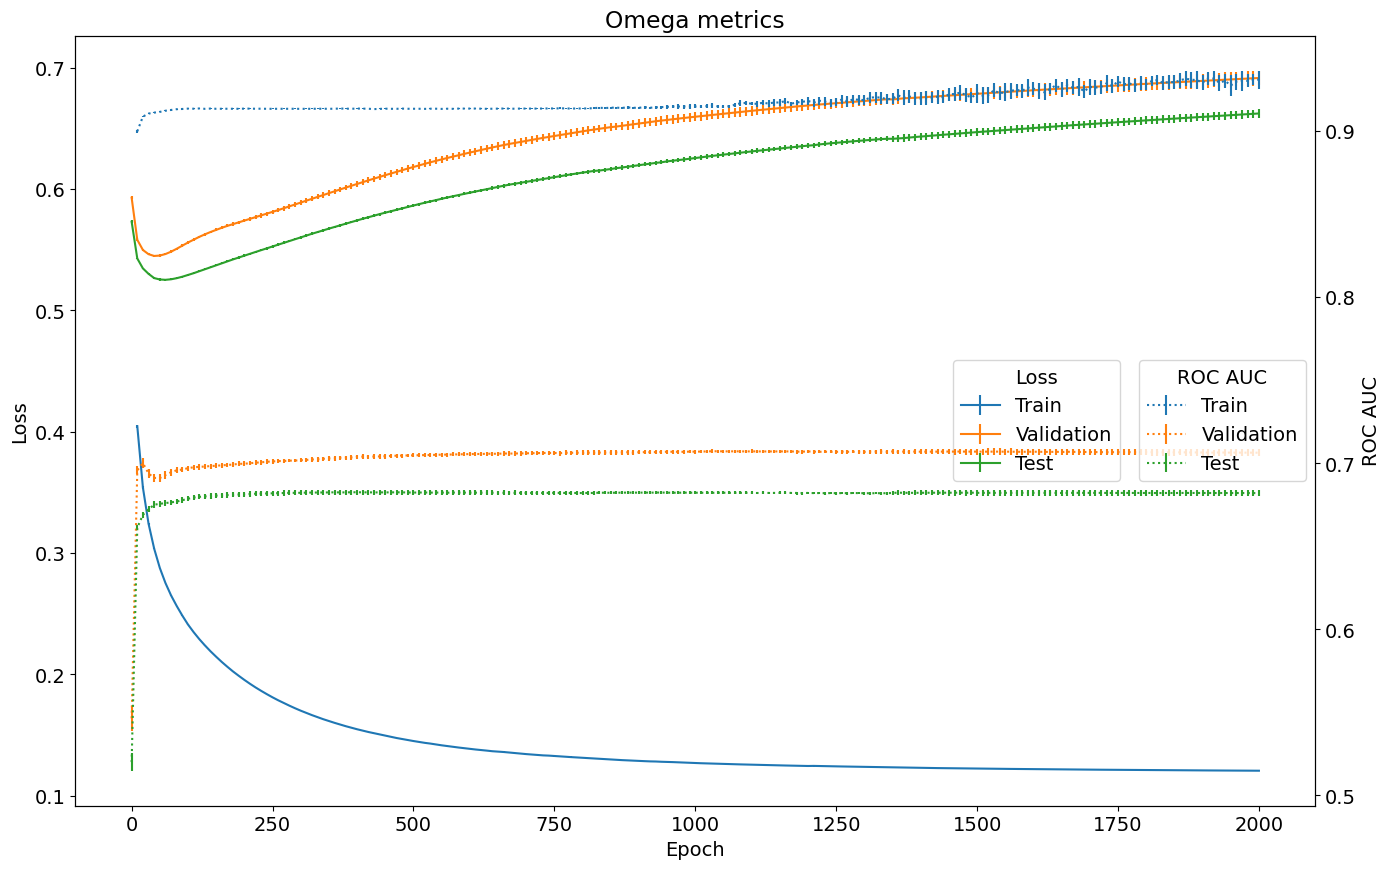

In [17]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Omega metrics')

ax1.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['loss_train_mean'][1:],
    yerr=epoch_metrics['loss_train_std'][1:],
    ls='-',
    label='Train')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_val_mean'],
    yerr=epoch_metrics['loss_val_std'],
    ls='-',
    label='Validation')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_test_mean'],
    yerr=epoch_metrics['loss_test_std'],
    ls='-',
    label='Test')

# ax1.plot(
#     epoch_metrics.index[1:],
#     epoch_metrics['loss_train_mean'][1:],
#     # yerr=epoch_metrics['loss_train_std'][1:],
#     ls='-',
#     label='Train')

# ax1.plot(
#     epoch_metrics.index,
#     epoch_metrics['loss_val_mean'],
#     # yerr=epoch_metrics['loss_val_std'],
#     ls='-',
#     label='Validation')

# ax1.plot(
#     epoch_metrics.index,
#     epoch_metrics['loss_test_mean'],
#     # yerr=epoch_metrics['loss_test_std'],
#     ls='-',
#     label='Test')

ax1.legend(loc='center right', title='Loss', bbox_to_anchor=[0.85, 0.5])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

ax2 = ax1.twinx()

ax2.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['auc_train_mean'][1:],
    yerr=epoch_metrics['auc_train_std'][1:],
    ls=':',
    label='Train')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_val_mean'],
    yerr=epoch_metrics['auc_val_std'],
    ls=':',
    label='Validation')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_test_mean'],
    yerr=epoch_metrics['auc_test_std'],
    ls=':',
    label='Test')

# ax2.plot(
#     epoch_metrics.index[1:],
#     epoch_metrics['auc_train_mean'][1:],
#     # yerr=epoch_metrics['auc_train_std'][1:],
#     ls=':',
#     label='Train')

# ax2.plot(
#     epoch_metrics.index,
#     epoch_metrics['auc_val_mean'],
#     # yerr=epoch_metrics['auc_val_std'],
#     ls=':',
#     label='Validation')

# ax2.plot(
#     epoch_metrics.index,
#     epoch_metrics['auc_test_mean'],
#     # yerr=epoch_metrics['auc_test_std'],
#     ls=':',
#     label='Test')

ax2.legend(loc='center right', title='ROC AUC', bbox_to_anchor=[1, 0.5])
ax2.set_ylabel('ROC AUC')

plt.savefig(f'reports/images/citeseer/structural_omega_gcn_cossim_training_metrics_{n_layers_gcn}gslayers.pdf')

### Comparing Validation Performance for All Layer numbers

In [18]:
n_layers_list = range(1, 4)

In [19]:
mean_auc_val_dict = {}
mean_loss_val_dict = {}
std_auc_val_dict = {}
std_loss_val_dict = {}
for n_layers_gcn in n_layers_list:
    metrics = StructuralOmegaGCNCosSim.read_metrics(dataset='citeseer', n_layers_gcn=n_layers_gcn)
    mean_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].mean()
    
    auc_val = mean_df['auc_val']
    loss_val = mean_df['loss_val']
    mean_auc_val_dict[n_layers_gcn] = auc_val
    mean_loss_val_dict[n_layers_gcn] = loss_val

    std_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].std()

    auc_val = std_df['auc_val']
    loss_val = std_df['loss_val']
    std_auc_val_dict[n_layers_gcn] = auc_val
    std_loss_val_dict[n_layers_gcn] = loss_val

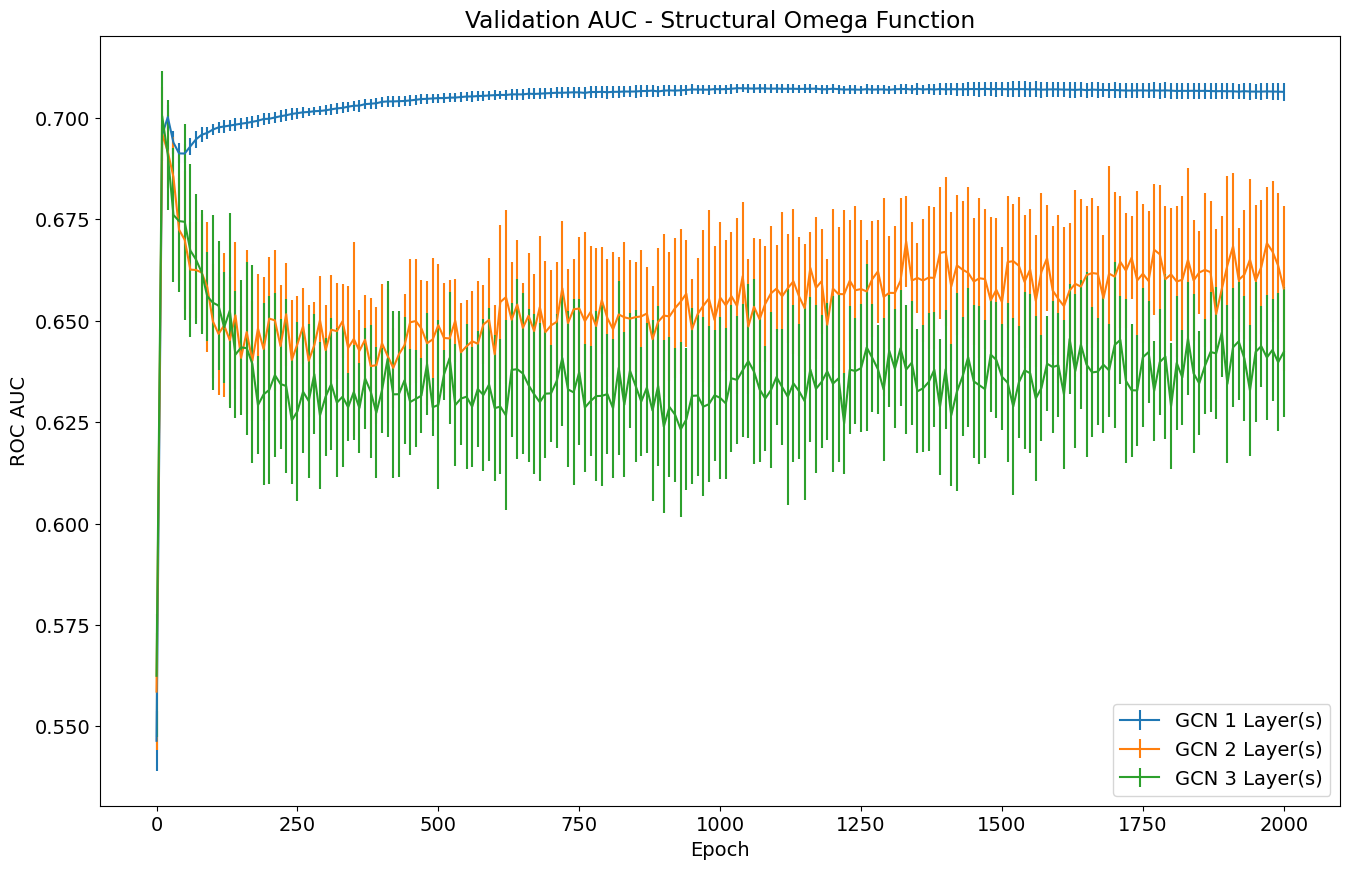

In [20]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Validation AUC - Structural Omega Function')

for n_layers in mean_auc_val_dict:
    ax1.errorbar(
        mean_auc_val_dict[n_layers].index,
        mean_auc_val_dict[n_layers],
        yerr=std_auc_val_dict[n_layers],
        ls='-',
        label=f'GCN {n_layers} Layer(s)')

# ax1.set_xlim(-50, 5000)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('ROC AUC')

ax1.legend()

## Score Best model

In [21]:
n_layers_list = range(1, 4)

In [22]:
full_metrics = []
for n_layers_gcn in n_layers_list:
    metrics = StructuralOmegaGCNCosSim.read_metrics(
        dataset='citeseer',
        n_layers_gcn=n_layers_gcn)
    metrics['n_layers_gcn'] = n_layers_gcn
    full_metrics.append(metrics)
full_metrics = pd.concat(full_metrics)

In [23]:
best_model_metrics = full_metrics.sort_values('auc_val', ascending=False).iloc[0]
best_model_metrics

run              8.000000
epoch           10.000000
loss_train       0.540451
loss_val         0.564723
loss_test        0.544813
auc_train        0.834594
auc_val          0.721129
auc_test         0.675883
n_layers_gcn     3.000000
Name: 1609, dtype: float64

In [24]:
best_model_metrics.to_json('models/structural_omega_grapn_sage_cossim/citeseer/best_model_info.json')